# Aprendendo a usar DATA AUGMENTATION (com ResNet50)

POE HAVER UM ERRO GIGANTE NA HORA DE SALVAR PRA JPG

Data Aug: https://www.tensorflow.org/tutorials/images/data_augmentation </br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers

ResNet:
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 </br>
https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Rescaling
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory

!pip install pydicom
import numpy as np
import pydicom
from PIL import Image
import os

import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.3 MB/s 


In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Ajustando o DS

## Baixando o DS

In [ ]:
!kaggle datasets download -d pedroamaro/smaller-rsna-ds-train-test

100% 7.25G/7.25G [01:44<00:00, 69.7MB/s]
100% 7.25G/7.25G [01:44<00:00, 74.2MB/s]


In [ ]:
!unzip /content/smaller-rsna-ds-train-test.zip | awk 'BEGIN {ORS=" "} {if(NR%1000==0)print "."}'
!rm /content/smaller-rsna-ds-train-test.zip

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
print('Numero de imagens: NO')
!ls /content/small_rsna_ds_train/no | wc -l
print('Numero de imagens: YES')
!ls /content/small_rsna_ds_train/yes | wc -l

Numero de imagens: NO
20047
Numero de imagens: YES
3287


## Salvando como JPG e aplicando full windowing

In [ ]:
!mkdir small_rsna_ds_as_jpg
!mkdir /content/small_rsna_ds_as_jpg/no
!mkdir /content/small_rsna_ds_as_jpg/yes

!mkdir test_as_jpg
!mkdir test_as_jpg/no
!mkdir test_as_jpg/yes

In [ ]:
def segment_circle(windowed):
    original = windowed.copy().astype("uint8")
    mask = np.zeros(original.shape, dtype=np.uint8)
    gray = original
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)
    cnts = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        area = cv2.contourArea(c)
        if len(approx) > 4 and area > 10000 and area < 500000:
            ((x, y), r) = cv2.minEnclosingCircle(c)
            cv2.circle(mask, (int(x), int(y)), int(r), (255, 255, 255), -1)
            cv2.circle(original, (int(x), int(y)), int(r), (36, 255, 12), 0)
    x,y,w,h = cv2.boundingRect(mask)
    mask_ROI = mask[y:y+h, x:x+w]
    image_ROI = original[y:y+h, x:x+w]
    result = cv2.bitwise_and(image_ROI, image_ROI, mask=mask_ROI)
    return result, (x, y, w, h)

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(img, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img


def preprocess_and_segment(path, make_correct=True):    
    dcm = pydicom.dcmread(path)
    if make_correct and (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)

    sample = dcm.pixel_array.astype("float32") * dcm.RescaleSlope + dcm.RescaleIntercept

    brain_window = window_image(sample, 40, 80)
    dural_window = window_image(sample, 80, 200)
    bone_window = window_image(sample, 600, 2800)

    brain_window, (x,y,w,h) = segment_circle(brain_window)
    if brain_window is None:
        return np.zeros((512, 512, 3))
    dural_window = dural_window[y:y+h, x:x+w]
    bone_window = bone_window[y:y+h, x:x+w]
    
    brain_window = (brain_window - (0.)) / 80.
    dural_window = (dural_window - (-20.)) / 200.
    bone_window = (bone_window - (-1200.)) / 2800.
    img_3ch = np.dstack([brain_window, dural_window, bone_window]).astype("float32")

    return img_3ch


def save_W_as_jpg(path, id, dest_folder):

  im_3ch = preprocess_and_segment(path)

  im = window_image(im_3ch, 40, 80) #talvez tenha um erro gigantesco nessa linha

  rescaled_im = (np.maximum(im, 0)/im.max())*255.0
  final_im = np.uint8(rescaled_im)

  final_im = Image.fromarray(final_im)
  final_im.save(dest_folder+id+'.jpg')

### Para o conjunto Train

In [ ]:
train_path = "/content/small_rsna_ds_train/yes/"
folder = os.listdir("/content/small_rsna_ds_train/yes/")
dest_folder = "/content/small_rsna_ds_as_jpg/yes/"

for id_ in folder:
  img_id = id_[:12]
  save_W_as_jpg(train_path + f"{id_}", img_id, dest_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
train_path = "/content/small_rsna_ds_train/no/"
folder = os.listdir("/content/small_rsna_ds_train/no/")
dest_folder = "/content/small_rsna_ds_as_jpg/no/"

for id_ in folder:
  img_id = id_[:12]
  save_W_as_jpg(train_path + f"{id_}", img_id, dest_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print('Numero de imagens: NO')
!ls /content/small_rsna_ds_as_jpg/no/ | wc -l
print('Numero de imagens: YES')
!ls /content/small_rsna_ds_as_jpg/yes/ | wc -l

Numero de imagens: NO
20047
Numero de imagens: YES
3287


### Para o conjunto Test

In [ ]:
train_path = "/content/small_rsna_ds_test/yes/"
folder = os.listdir("/content/small_rsna_ds_test/yes/")
dest_folder = "/content/test_as_jpg/yes/"

for id_ in folder:
  img_id = id_[:12]
  save_W_as_jpg(train_path + f"{id_}", img_id, dest_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
train_path = "/content/small_rsna_ds_test/no/"
folder = os.listdir("/content/small_rsna_ds_test/no/")
dest_folder = "/content/test_as_jpg/no/"

for id_ in folder:
  img_id = id_[:12]
  save_W_as_jpg(train_path + f"{id_}", img_id, dest_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print('Numero de imagens: NO')
!ls /content/test_as_jpg/no/ | wc -l
print('Numero de imagens: YES')
!ls /content/test_as_jpg/yes/ | wc -l

Numero de imagens: NO
10022
Numero de imagens: YES
1643


# Carregando o dataset

In [ ]:
train_data = image_dataset_from_directory(
    "/content/small_rsna_ds_as_jpg",
     labels='inferred',
     validation_split=1/3,
     subset="training",
     seed=123,
     batch_size = 64,
     color_mode = "rgb"
     )

Found 23334 files belonging to 2 classes.
Using 15556 files for training.


In [ ]:
val_data = image_dataset_from_directory(
    "/content/small_rsna_ds_as_jpg",
     labels='inferred',
     validation_split=1/3,
     subset="validation",
     seed=123,
     batch_size = 64,
     color_mode = "rgb"
)

Found 23334 files belonging to 2 classes.
Using 7778 files for validation.


In [ ]:
test_data = image_dataset_from_directory(
    "/content/test_as_jpg",
     labels='inferred',
     label_mode="int",
     batch_size = 64,
     color_mode = "rgb"
     )

Found 11665 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names

## Normalizando e Pegando o tamanho de entrada

In [ ]:
normalization_layer = Rescaling(1./255)

normalized_data = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_data))

normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))
val_image_batch, val_labels_batch = next(iter(normalized_val_data))

normalized_test_data = test_data.map(lambda x, y: (normalization_layer(x), y))
test_image_batch, test_labels_batch = next(iter(normalized_test_data))

# Data Aug

## Basics

In [ ]:
#Novos imports
from keras.layers import RandomFlip, RandomRotation, RandomCrop
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
id = random.choice(os.listdir("/content/small_rsna_ds_as_jpg/yes"))
id

'ID_ee7904292.jpg'

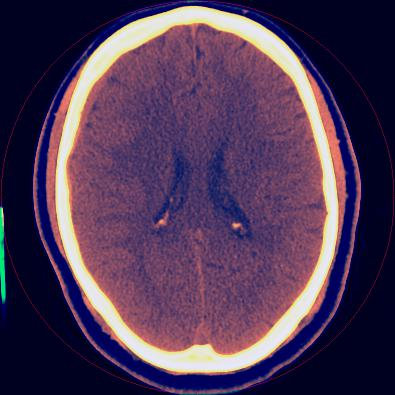

In [ ]:
img = cv2.imread("/content/small_rsna_ds_as_jpg/yes/" + id)
cv2_imshow(img)

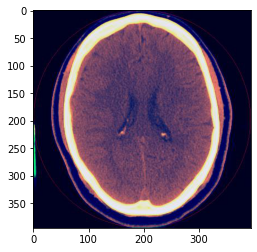

In [ ]:
img = plt.imread("/content/small_rsna_ds_as_jpg/yes/" + id)
plt.imshow(img)

In [ ]:
flip = Sequential([
  RandomFlip("horizontal"),
])
#tf.image.flip_left_right é melhor

rotate = Sequential([
  RandomRotation(0.2),
])

flip_rotate = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

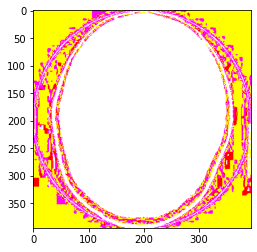

In [ ]:
result = flip(img)
plt.imshow(result)

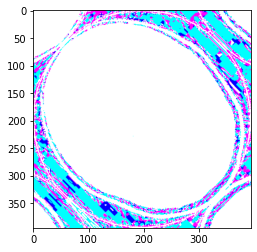

In [ ]:
result = rotate(img)
plt.imshow(result)

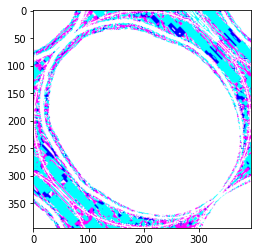

In [ ]:
result = flip_rotate(img)
plt.imshow(result)

## Para todo um diretorio

In [ ]:
id = []
img = []

for i in range(16):
  id.append( random.choice(os.listdir("/content/small_rsna_ds_as_jpg/yes")) )
  img.append( cv2.imread("/content/small_rsna_ds_as_jpg/yes/" + id[i]) )

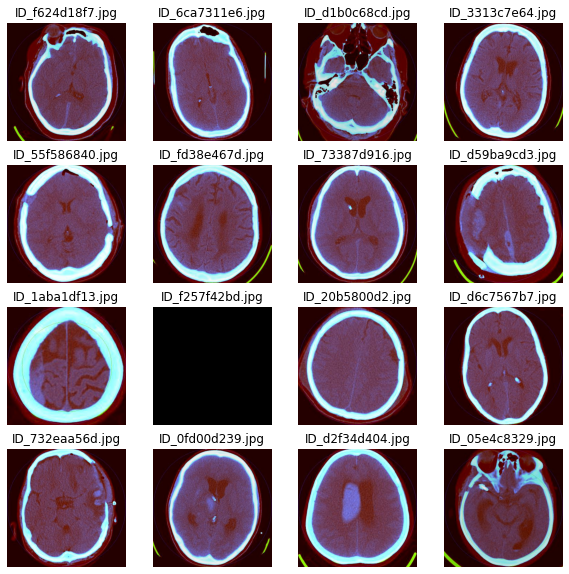

In [ ]:
#ORIGINAL
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4,4, i+1)
  plt.title(id[i])
  plt.imshow(img[i])
  plt.axis('off')

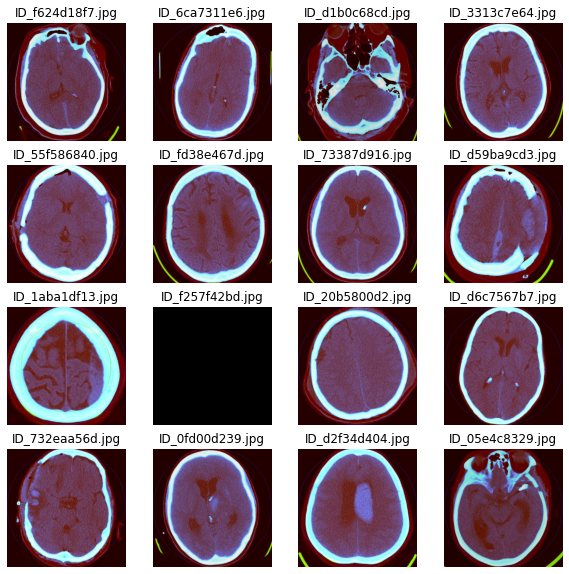

In [ ]:
#FLIPED
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4,4, i+1)
  plt.title(id[i])
  plt.imshow(tf.image.flip_left_right(img[i]))
  plt.axis('off')

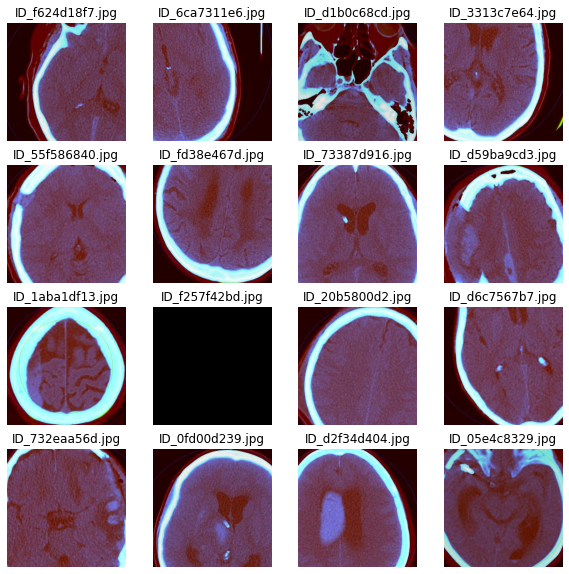

In [ ]:
#CROPED
""" o que eu coloco em size? o size que o crop vai ter ou que a img q vai ser cropada tem?"""
plt.figure(figsize=(10, 10))
for i in range(16):
  seed = (i, 0)
  ax = plt.subplot(4,4, i+1)
  plt.title(id[i])
  plt.imshow(tf.image.stateless_random_crop(img[i], size=[250, 250, 3], seed=seed))
  plt.axis('off')

##test
qual o tamanho da img?

In [ ]:
test_id = random.choice(os.listdir("/content/small_rsna_ds_as_jpg/yes"))
test_id

'ID_03bf555d2.jpg'

In [ ]:
test = cv2.imread("/content/small_rsna_ds_as_jpg/yes/" + test_id)

In [ ]:
test.shape

(441, 441, 3)